# NBA DATA ANALYSIS
## Objective
- H0: Taller NBA players do not have the ability to improve their overall seasonal performance
- H1: Taller NBA players have the ability to improve their overall seasonal performance.
- What we mean by this is do categorized taller NBA players have the ability to improve drastically in their weaker areas significantly as a shorter player who is stronger in those fields. Or is there no room for improvement and taller people generally have no chance of improvement. We are testing whether it is possible for improvement not whether it is optimal for team and seasonal performance.
    - What is considered short or tall?  (Categorized) [Box plot]
        - Shorter players are considered to be below 6'8 anything above is tall according to google.
    - Compare Height/Wingspan to FT,2P,3P Percentage (Done - regressional analysis)
        - Does Taking more Free throws lead to an increased FT%
    - What are taller NBA players currently good at and what positions predominantly played (Test of mean)
        - Centers, PF vs Small forward, Shooting, and Point guards 
    - Taller vs shorter players in the NBA (H0: Taller players are more dominant as centers compared to shorter players)
        - Dominant in terms of Blocks, rebounds(O/D), steals
    - Do they have the opportunity to play other positions rather than "big men" positions
        - Look at point attempts for Centers, PF vs Small forward, Shooting, and Point guards and see if 
          'big men' should take more attempts

## Notes
- Merged Data only considers players who have above FTA and have a reported Height and Wingspan from the combine data to be eligible for comparision.
- To account for error there are Players who have a reported Height but was not reported in combine data

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats as st

### Read In CSVs

In [108]:
raw_combine_data=pd.read_csv('Resources/raw_combine_data.csv')
raw_nba_data=pd.read_csv('Resources/raw_nba_data.csv')

### Finding Duplicates

In [109]:
nba_duplicates=raw_nba_data[raw_nba_data.duplicated(['PLAYER'])]
combine_duplicates=raw_combine_data[raw_combine_data.duplicated(['PLAYER'])]

### Drop Duplicates from Dataframes

In [110]:
dropped_combine_data=raw_combine_data.drop_duplicates(subset='PLAYER',keep='first')
dropped_nba_data=raw_nba_data.drop_duplicates(subset='PLAYER',keep='first')

### Merge DataFrames

In [111]:
merged_data_df=dropped_combine_data.merge(dropped_nba_data, on='PLAYER')

### Remove Players Who Didn't Take Enough Shots to Include in Analysis

In [112]:
merged_data_df=merged_data_df[merged_data_df['3PA']>10]
merged_data_df=merged_data_df[merged_data_df['2PA']>10]
merged_data_df=merged_data_df[merged_data_df['FTA']>10]

### Drop Rows w/ Missing Wingspan & Height Data

In [113]:
merged_data_df=merged_data_df.dropna(subset=['WINGSPAN'])
merged_data_df=merged_data_df.dropna(subset=['HEIGHT\xa0W/O\xa0SHOES'])

merged_data_df.reset_index(inplace=True)
merged_data_df.drop(axis=1, labels='index', inplace=True)

### Export as CSV

In [114]:
merged_data_df.to_csv("Resources/merged_data.csv",index=False)

### Finding Outliers for 2PA, 3PA, FTA

In [115]:
# Calculate the IQR and quantitatively determine if there are any potential outliers and append them to a dataframe
df=pd.DataFrame({'2PA':["","","","","","",""],
                 'FTA':["","","","","","",""],
                 '3PA':["","","","","","",""]
                })
df=df.set_index(keys=[["Lower Quartile","Median","Upper Quartile","IQR","Lower Bound","Upper Bound","Std"]]) #set index

for data in df:
    quartiles = merged_data_df[data].quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    median= quartiles[0.5]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    df[data][0]=lowerq
    df[data][1]=median
    df[data][2]=upperq
    df[data][3]=iqr
    df[data][4]=lower_bound
    df[data][5]=upper_bound
    df[data][6]=merged_data_df[data].std()
df

,2PA,FTA,3PA
Lower Quartile,110.5,42.5,78.5
Median,215,83,154
Upper Quartile,371.5,142.5,248
IQR,261,100,169.5
Lower Bound,-281,-107.5,-175.75
Upper Bound,763,292.5,502.25
Std,214.517,110.703,130.481


### Wingspan Conversion to Inches

In [116]:
wingspan = []
wingspan_convert=[]

wingspan = merged_data_df['WINGSPAN']
wingspan_list = wingspan.tolist()
for wingspan in wingspan_list:
    wingspan_cleaned = wingspan.strip("'").split("'")
    wingspan_convert.append((int(wingspan_cleaned[0])*12)+(float(wingspan_cleaned[1])))

merged_data_df['WINGSPAN']=wingspan_convert

### Height w/o Shoes Conversion to Inches

In [117]:
height_wo_shoes = []
height_wo_shoes_convert=[]

height_wo_shoes = merged_data_df['HEIGHT\xa0W/O\xa0SHOES']
height_wo_shoes_list = height_wo_shoes.tolist()
height_wo_shoes_list
for height in height_wo_shoes_list:
    height_cleaned = str(height).strip(" ' ").split("'")
    height_wo_shoes_convert.append((int(height_cleaned[0])*12)+(float(height_cleaned[1])))
    
merged_data_df['HEIGHT\xa0W/O\xa0SHOES']=height_wo_shoes_convert

# Scatter Plots

## Wingspan vs. Free Throws

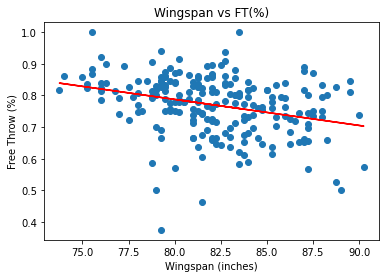

The line of best fit is : y = -0.01x + 1.45
The correlation between both factors is -0.3


In [118]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(wingspan_convert, merged_data_df['FT%'] )
regress_values = np.array(wingspan_convert) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(wingspan_convert,regress_values, color='red')
plt.scatter(x=wingspan_convert, y=merged_data_df['FT%'])
plt.ylabel('Free Throw (%)')
plt.xlabel('Wingspan (inches)')
plt.title("Wingspan vs FT(%)")
plt.show()
print(f"The line of best fit is : {line_eq}")
correlation = st.pearsonr(wingspan_convert,merged_data_df['FT%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Wingspan vs. 2P%

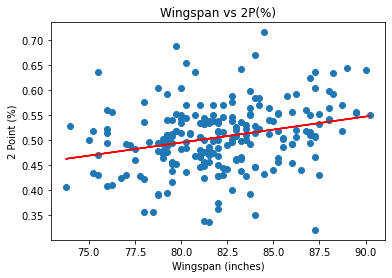

The line of best fit is : y = 0.01x + 0.08
The correlation between both factors is 0.27


In [119]:

(slope, intercept, rvalue, pvalue, stderr) = linregress(wingspan_convert, merged_data_df['2P%'] )
regress_values = np.array(wingspan_convert) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(wingspan_convert,regress_values, color='red')
plt.scatter(x=wingspan_convert, y=merged_data_df['2P%'])
plt.ylabel('2 Point (%)')
plt.xlabel('Wingspan (inches)')
plt.title("Wingspan vs 2P(%)")
plt.show()
print(f"The line of best fit is : {line_eq}")
correlation = st.pearsonr(wingspan_convert,merged_data_df['2P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Wingspan vs. 3P%

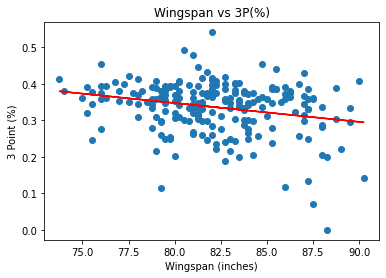

The line of best fit is : y = -0.01x + 0.76
The correlation between both factors is -0.25


In [120]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(wingspan_convert, merged_data_df['3P%'] )
regress_values = np.array(wingspan_convert) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(wingspan_convert,regress_values,color='red')
plt.scatter(x=wingspan_convert, y=merged_data_df['3P%'])
plt.ylabel('3 Point (%)')
plt.xlabel('Wingspan (inches)')
plt.title("Wingspan vs 3P(%)")
plt.show()
print(f"The line of best fit is : {line_eq}")
correlation = st.pearsonr(wingspan_convert,merged_data_df['3P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Height vs. FT%

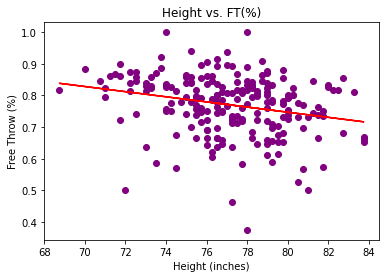

In [121]:
(correlation_coefficient) = st.pearsonr(height_wo_shoes_convert, merged_data_df['FT%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(height_wo_shoes_convert, merged_data_df['FT%'])

#Slope formula 'y=mx+b'
y = slope * np.array(height_wo_shoes_convert) + intercept

plt.scatter(x = height_wo_shoes_convert, y = merged_data_df['FT%'], color = "purple")
plt.xlabel('Height (inches)')
plt.ylabel('Free Throw (%)')
plt.title('Height vs. FT(%)')

plt.plot(height_wo_shoes_convert, y, color = 'red')
plt.show()

## Height vs. 2P%

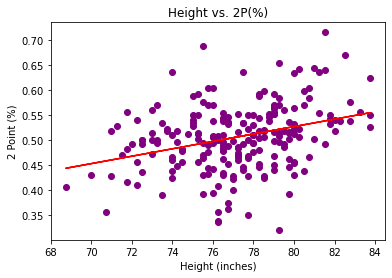

In [122]:


(correlation_coefficient) = st.pearsonr(height_wo_shoes_convert, merged_data_df['2P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(height_wo_shoes_convert, merged_data_df['2P%'])

#Slope formula 'y=mx+b'
y = slope * np.array(height_wo_shoes_convert) + intercept

plt.scatter(x = height_wo_shoes_convert, y = merged_data_df['2P%'], color = "purple")
plt.xlabel('Height (inches)')
plt.ylabel('2 Point (%)')
plt.title('Height vs. 2P(%)')

plt.plot(height_wo_shoes_convert, y, color = 'red')
plt.show()

## Height vs. 3P%

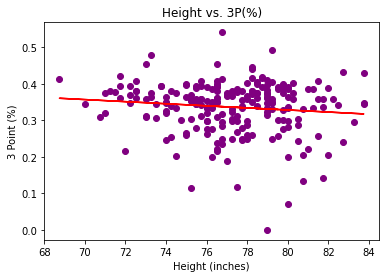

In [123]:

(correlation_coefficient) = st.pearsonr(height_wo_shoes_convert, merged_data_df['3P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(height_wo_shoes_convert, merged_data_df['3P%'])

#Slope formula 'y=mx+b'
y = slope * np.array(height_wo_shoes_convert) + intercept

plt.scatter(x = height_wo_shoes_convert, y = merged_data_df['3P%'], color = "purple")
plt.xlabel('Height (inches)')
plt.ylabel('3 Point (%)')
plt.title('Height vs. 3P(%)')

plt.plot(height_wo_shoes_convert, y, color = 'red')
plt.show()

In [124]:
ratio_wing_over_height = []

for i in range(len(wingspan_convert)):
    ratio_wing_over_height.append(wingspan_convert[i] / height_wo_shoes_convert[i])

## Ratio vs. FT%

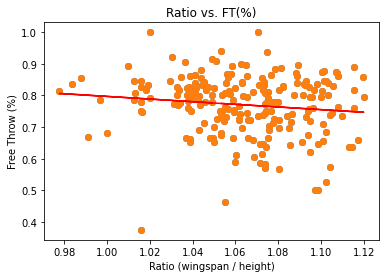

In [125]:
plt.scatter(ratio_wing_over_height,merged_data_df["FT%"])

correlation_coefficient = st.pearsonr(ratio_wing_over_height, merged_data_df['FT%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(ratio_wing_over_height, merged_data_df['FT%'])

y = slope * np.array(ratio_wing_over_height) + intercept

plt.scatter(x = ratio_wing_over_height, y = merged_data_df['FT%'])
plt.xlabel('Ratio (wingspan / height)')
plt.ylabel('Free Throw (%)')
plt.title('Ratio vs. FT(%)')

plt.plot(ratio_wing_over_height, y, color = 'red')
plt.show()

## Ratio vs. 2P%

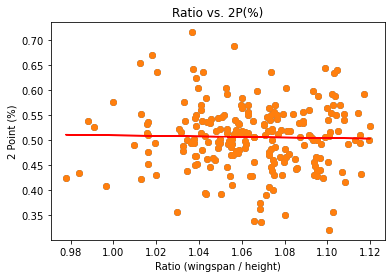

In [126]:
plt.scatter(ratio_wing_over_height,merged_data_df["2P%"])

correlation_coefficient = st.pearsonr(ratio_wing_over_height, merged_data_df['2P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(ratio_wing_over_height, merged_data_df['2P%'])

y = slope * np.array(ratio_wing_over_height) + intercept

plt.scatter(x = ratio_wing_over_height, y = merged_data_df['2P%'])
plt.xlabel('Ratio (wingspan / height)')
plt.ylabel('2 Point (%)')
plt.title('Ratio vs. 2P(%)')

plt.plot(ratio_wing_over_height, y, color = 'red')
plt.show()

## Ratio vs. 3P%

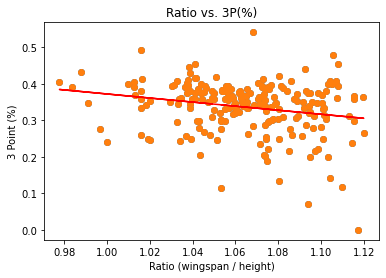

In [127]:

plt.scatter(ratio_wing_over_height,merged_data_df["3P%"])

(correlation_coefficient) = st.pearsonr(ratio_wing_over_height, merged_data_df['3P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(ratio_wing_over_height, merged_data_df['3P%'])

y = slope * np.array(ratio_wing_over_height) + intercept

plt.scatter(x = ratio_wing_over_height, y = merged_data_df['3P%'])
plt.xlabel('Ratio (wingspan / height)')
plt.ylabel('3 Point (%)')
plt.title('Ratio vs. 3P(%)')

plt.plot(ratio_wing_over_height, y, color = 'red')
plt.show()

## SEASON STAT ANALYSIS:

In [177]:
season_data_df = pd.read_csv('Resources/season_data_height.csv')
merged2_df = season_data_df.merge(dropped_combine_data, on = "PLAYER")
merged2_df.to_csv("Resources/merged2.csv", index = False)

merged3_df = dropped_nba_data.merge(season_data_df)
merged3_df.to_csv('Resources/merged3.csv', index = False)

In [54]:
print("Total Rows/Columns NBA Stats", dropped_nba_data.shape)
print("Total Rows/Columns Combined Data", dropped_combine_data.shape)
dropped_nba_data.head()

Total Rows/Columns NBA Stats (514, 31)
Total Rows/Columns Combined Data (1327, 10)


,Rk,PLAYER,Unnamed: 2,Pos,Age,Tm,G,GS,MP,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,173,Aaron Gordon,gordoaa01,PF,24,ORL,58,58,1914,314,...,0.675,103,338,441,215,50,36,94,116,833
1,216,Aaron Holiday,holidaa01,PG,23,IND,58,26,1368,202,...,0.861,21,111,132,193,45,13,75,102,546
2,355,Abdel Nader,naderab01,SF,26,OKC,48,5,756,100,...,0.774,14,76,90,35,20,20,36,65,287
3,338,Adam Mokoka,mokokad01,SG,21,CHI,11,0,112,12,...,0.500,7,3,10,4,4,0,2,17,32
4,429,Admiral Schofield,schofad01,SF,22,WAS,27,2,293,30,...,0.692,6,28,34,14,8,3,7,41,83


In [150]:
raw_nba_data_height=pd.read_csv('Resources/season_data_height.csv')
raw_nba_data_height.loc[raw_nba_data_height['PLAYER'].duplicated(), :]
raw_nba_data_height[raw_nba_data_height.isna().any(axis=1)].drop(columns='COLLEGE')

,PLAYER,TEAM,AGE,HEIGHT,WEIGHT,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER,GP,PTS,REB,AST,NETRTG,OREB%,DREB%,USG%,TS%,AST%
150,Enes Kanter,BOS,28,6'10,250,Turkey,2011,1,3,51,8.2,7.7,1.0,8.3,15.00%,26.60%,18.50%,59.40%,8.20%
312,Langston Galloway,DET,28,6'1,200,USA,Undrafted,Undrafted,Undrafted,66,10.3,2.3,1.5,4.4,1.90%,6.80%,14.90%,58.40%,8.90%
472,Tony Snell,DET,28,6'6,213,USA,2013,1,20,59,8.0,1.9,2.2,5.5,0.50%,6.40%,11.00%,59.80%,11.00%


In [80]:
#Previous merge check
dropped_nba_data.merge(dropped_combine_data[['PLAYER','HEIGHT\xa0W/O\xa0SHOES']])

,Rk,PLAYER,Unnamed: 2,Pos,Age,Tm,G,GS,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,HEIGHT,HEIGHT W/O SHOES
0,173,Aaron Gordon,gordoaa01,PF,24,ORL,58,58,1914,314,...,338,441,215,50,36,94,116,833,6' 7.5'',6' 7.5''
1,216,Aaron Holiday,holidaa01,PG,23,IND,58,26,1368,202,...,111,132,193,45,13,75,102,546,6' 0.75'',5' 11.75''
2,429,Admiral Schofield,schofad01,SF,22,WAS,27,2,293,30,...,28,34,14,8,3,7,41,83,6' 0.75'',6' 4''
3,222,Al Horford,horfoal01,C,33,PHI,60,57,1848,289,...,320,412,244,52,55,65,128,722,6' 7.5'',6' 8''
4,77,Alec Burks,burksal01,SG,28,TOT,59,18,1612,283,...,219,262,171,58,17,85,120,891,7' 0'',6' 5''
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,90,Willie Cauley-Stein,caulewi01,C,26,TOT,54,39,1097,175,...,231,315,70,49,61,40,121,390,6' 0.5'',6' 11.25''
302,105,Zach Collins,colliza01,PF,22,POR,3,3,86,9,...,8,12,6,0,2,6,11,27,6' 11.5'',6' 10.25''
303,280,Zach LaVine,lavinza01,SG,24,CHI,60,60,2085,539,...,248,289,254,88,28,206,131,1530,6' 4'',6' 4.5''
304,445,Zhaire Smith,smithzh01,SG,20,PHI,7,0,32,3,...,2,2,2,3,0,2,4,8,6' 5.5'',6' 2.75''


In [181]:
merged_data_df.groupby('POS')[['HEIGHT\xa0W/O\xa0SHOES', 'BLK', 'FT%', '2P%', '3P%', 'FTA', '2PA', '3PA']].mean()

,HEIGHT W/O SHOES,BLK,FT%,2P%,3P%,FTA,2PA,3PA
POS,,,,,,,,
C,82.208333,61.833333,0.696000,0.568500,0.261333,101.833333,275.166667,120.666667
C-PF,82.600000,36.600000,0.747400,0.571000,0.325000,103.000000,211.800000,120.600000
PF,79.970588,29.382353,0.730706,0.534353,0.309971,106.794118,258.852941,129.941176
PF-C,81.500000,59.200000,0.811200,0.541000,0.390800,183.400000,401.200000,140.000000
PF-SF,78.500000,22.500000,0.779750,0.496750,0.327250,95.500000,186.250000,156.000000
PG,73.477273,13.340909,0.799409,0.483205,0.345091,137.704545,316.704545,199.613636
PG-SG,75.000000,18.000000,0.782000,0.516833,0.324500,105.500000,355.833333,233.333333
SF,78.322368,19.657895,0.749184,0.508158,0.339368,101.105263,255.578947,164.000000
SF-PF,78.687500,43.750000,0.781000,0.548000,0.347000,115.000000,347.000000,255.750000


In [23]:
merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] > 77.75,:].count()['PLAYER']

92

In [24]:
#Traditional Big men players are not as common and are mainly used to stretch the floor 
#rather than score points by posting up near the basket

merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] > 77.75,:][['PLAYER','HEIGHT\xa0W/O\xa0SHOES', 'FT%', '3PA', '3P%']].mean()

HEIGHT W/O SHOES     79.845109
FT%                   0.753446
3PA                 164.934783
3P%                   0.336054
dtype: float64

In [25]:
merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] < 77.75,:].count()['PLAYER']

120

In [26]:
merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] < 77.75,:][['HEIGHT\xa0W/O\xa0SHOES', 'FT%', '3PA', '3P%']].mean()

HEIGHT W/O SHOES     75.08125
FT%                   0.78450
3PA                 196.82500
3P%                   0.33795
dtype: float64

In [27]:
#Find the optimal height that people play for each of their positions
merged_data_df.groupby('Pos')['HEIGHT\xa0W/O\xa0SHOES'].min()

Pos
C        79.00
C-PF     79.00
PF       76.50
PF-SF    77.75
PG       68.75
SF       75.75
SF-PF    79.00
SG       70.75
Name: HEIGHT W/O SHOES, dtype: float64

In [28]:
merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] < 77.75,:][['HEIGHT\xa0W/O\xa0SHOES', 'FT%', '3PA', '3P%']].max()

HEIGHT W/O SHOES     77.500
FT%                   1.000
3PA                 769.000
3P%                   0.541
dtype: float64

In [29]:
merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] > 77.75,:][['HEIGHT\xa0W/O\xa0SHOES', 'FT%', '3PA', '3P%']].max()

HEIGHT W/O SHOES     83.750
FT%                   1.000
3PA                 454.000
3P%                   0.493
dtype: float64

In [187]:
#Traditional Big men players are not as common and are mainly used to stretch the floor 
#rather than score points by posting up near the basket
tall_avg_ser=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] >= 77.75,:][['FTA','FT%','2PA','2P%','3PA', '3P%']].mean()
tall_count=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] >= 77.75,:].count()['PLAYER']
short_avg_ser=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] < 77.75,:][['FTA','FT%','2PA','2P%','3PA', '3P%']].mean()
short_count=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] < 77.75,:].count()['PLAYER']

In [183]:
print(f"""
Number of Tall Players: {tall_count}
------------------------------------
{tall_avg_ser}""")
print(f"""
Number of Short Players: {short_count}
----------------------------------
{short_avg_ser}""")


Number of Tall Players: 99
------------------------------------
FTA    112.393939
FT%      0.752929
2PA    272.444444
2P%      0.525717
3PA    162.313131
3P%      0.334354
dtype: float64

Number of Short Players: 120
----------------------------------
FTA    115.758333
FT%      0.784500
2PA    275.341667
2P%      0.489742
3PA    196.825000
3P%      0.337950
dtype: float64


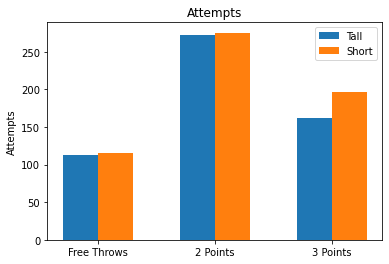

In [200]:
N = 3
tall_players_stats = (112.393939, 272.444444, 162.313131)
short_players_stats = (115.758333, 275.341667, 196.825000)

ind = np.arange(N) 
width = 0.30

plt.bar(ind, tall_players_stats, width, label='Tall')
plt.bar(ind + width, short_players_stats, width, label='Short')

plt.ylabel('Attempts')
plt.title('Attempts')

plt.xticks(ind + width / 2, ('Free Throws', '2 Points', '3 Points'))
plt.legend(loc='best')
plt.show()

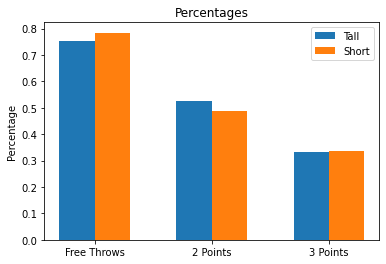

In [199]:
N = 3
tall_players_stats = (0.752929, 0.525717, 0.334354)
short_players_stats = (0.784500, 0.489742, 0.337950)

ind = np.arange(N) 
width = 0.30

plt.bar(ind, tall_players_stats, width, label='Tall')
plt.bar(ind + width, short_players_stats, width, label='Short')

plt.ylabel('Percentage')
plt.title('Percentages')

plt.xticks(ind + width / 2, ('Free Throws', '2 Points', '3 Points'))
plt.legend(loc='best')
plt.show()

In [184]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(merged_data_df['3PA'], merged_data_df['3P%'] )
regress_values = np.array(merged_data_df['3PA']) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

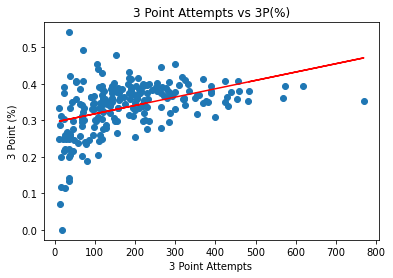

The line of best fit is : y = 0.0x + 0.29
The correlation between both factors is 0.42


In [185]:
plt.plot(merged_data_df['3PA'],regress_values,color='red')
plt.scatter(x=merged_data_df['3PA'], y=merged_data_df['3P%'])
plt.ylabel('3 Point (%)')
plt.xlabel('3 Point Attempts ')
plt.title("3 Point Attempts vs 3P(%)")
plt.show()
print(f"The line of best fit is : {line_eq}")
correlation = st.pearsonr(merged_data_df['3PA'],merged_data_df['3P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

In [186]:
## Low
correlation = st.pearsonr(merged_data_df['3P%'],merged_data_df['2P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
## High
correlation = st.pearsonr(merged_data_df['3PA'],merged_data_df['FT%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
correlation = st.pearsonr(merged_data_df['3PA'],merged_data_df['3P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
## Low
correlation = st.pearsonr(merged_data_df['3PA'],merged_data_df['2P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
correlation = st.pearsonr(merged_data_df['2PA'],merged_data_df['2P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
correlation = st.pearsonr(merged_data_df['2PA'],merged_data_df['3P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
correlation = st.pearsonr(merged_data_df['2PA'],merged_data_df['FT%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is -0.04
The correlation between both factors is 0.37
The correlation between both factors is 0.42
The correlation between both factors is -0.03
The correlation between both factors is 0.11
The correlation between both factors is 0.05
The correlation between both factors is 0.2
